# 🧠  Economic Context & Synthesis (EDA + Modeling)
## 🎯 Mục tiêu
Phân tích các **biến kinh tế vĩ mô** ảnh hưởng đến việc **khách hàng có gửi tiền (y)** hay không.  
Sau đó, xây dựng các mô hình dự đoán với **PySpark**, xử lý dữ liệu **mất cân bằng** bằng **SMOTE**,  và đánh giá mô hình bằng **Cross-validation**.


In [2]:
# Import các thư viện cần thiết
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Tạo SparkSession
spark = SparkSession.builder.appName("Hao_Economic_Context_Synthesis").getOrCreate()

# Đọc dữ liệu
data = spark.read.csv(r"E:\PJML_Big\marketing-bank-prediction\data\bank-additional\bank-additional-full.csv", header=True, sep=';', inferSchema=True)
print("Số dòng:", data.count())
data.printSchema()


Số dòng: 41188
root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- y: string (nullable = true)



## 🔍 2️⃣ EDA - Phân tích ảnh hưởng của các biến kinh tế vĩ mô
Ở đây ta tập trung vào 5 biến vĩ mô:
- `emp.var.rate` – tỷ lệ biến động việc làm  
- `cons.price.idx` – chỉ số giá tiêu dùng  
- `cons.conf.idx` – chỉ số niềm tin người tiêu dùng  
- `euribor3m` – lãi suất EURIBOR 3 tháng  
- `nr.employed` – số người có việc làm  

Ta sẽ xem xét **phân phối**, **tương quan** và **ảnh hưởng** của chúng tới biến mục tiêu `y`.


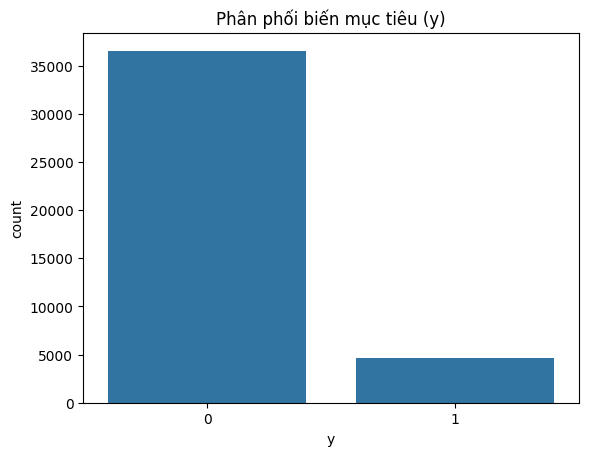

In [6]:
# Lấy dữ liệu cần thiết để vẽ
pdf = data.select(
    "`emp.var.rate`",
    "`cons.price.idx`",
    "`cons.conf.idx`",
    "euribor3m",
    "`nr.employed`",
    "y"
).toPandas()

# Chuyển y -> 0/1
pdf["y"] = pdf["y"].apply(lambda x: 1 if x == "yes" else 0)

# Phân phối biến mục tiêu
sns.countplot(data=pdf, x="y")
plt.title("Phân phối biến mục tiêu (y)")
plt.show()


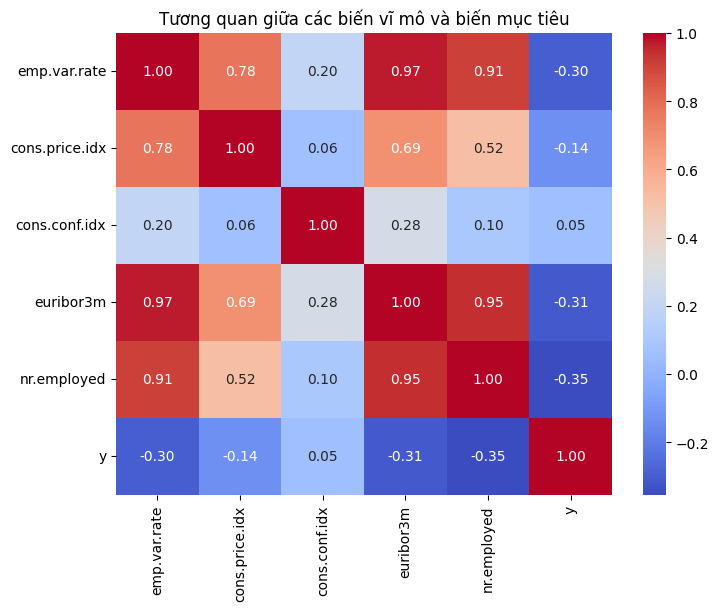

In [7]:
# Ma trận tương quan
plt.figure(figsize=(8,6))
sns.heatmap(pdf.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Tương quan giữa các biến vĩ mô và biến mục tiêu")
plt.show()


- Nhóm biến emp.var.rate, euribor3m, nr.employed có thể được rút gọn hoặc chọn 1–2 đại diện.

- Các biến có tương quan âm với y

- Khi các chỉ số kinh tế này tăng (biểu hiện cho tình hình kinh tế tốt hơn), khả năng khách hàng đồng ý gửi tiền (y=1) lại giảm.

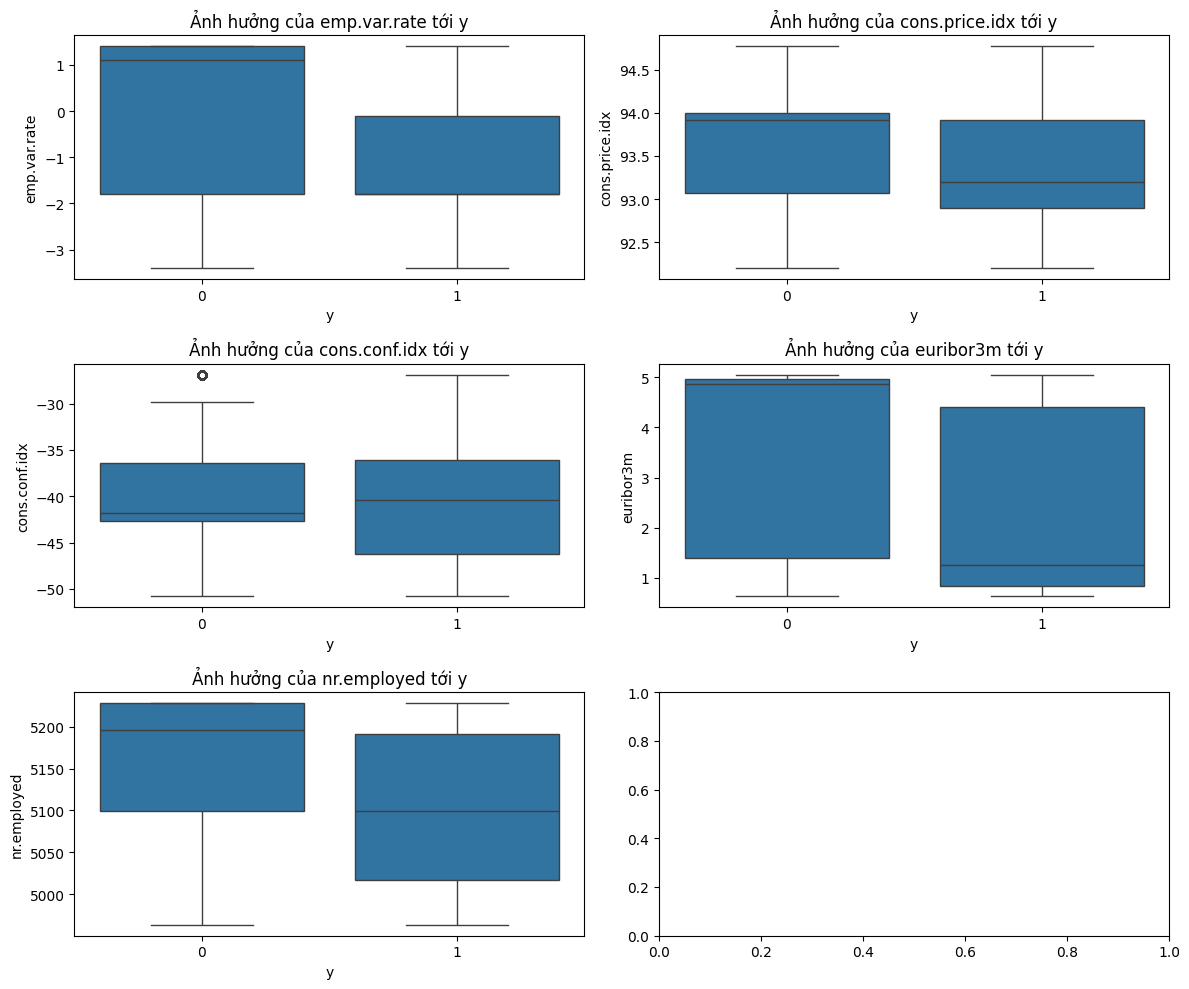

In [8]:
# Boxplot phân tích từng biến
fig, axes = plt.subplots(3,2, figsize=(12,10))
sns.boxplot(ax=axes[0,0], x="y", y="emp.var.rate", data=pdf)
axes[0,0].set_title("Ảnh hưởng của emp.var.rate tới y")

sns.boxplot(ax=axes[0,1], x="y", y="cons.price.idx", data=pdf)
axes[0,1].set_title("Ảnh hưởng của cons.price.idx tới y")

sns.boxplot(ax=axes[1,0], x="y", y="cons.conf.idx", data=pdf)
axes[1,0].set_title("Ảnh hưởng của cons.conf.idx tới y")

sns.boxplot(ax=axes[1,1], x="y", y="euribor3m", data=pdf)
axes[1,1].set_title("Ảnh hưởng của euribor3m tới y")

sns.boxplot(ax=axes[2,0], x="y", y="nr.employed", data=pdf)
axes[2,0].set_title("Ảnh hưởng của nr.employed tới y")

plt.tight_layout()
plt.show()


| Biến vĩ mô (`feature`) | Ý nghĩa kinh tế                 | Xu hướng khi biến tăng             | Ảnh hưởng đến khả năng gửi tiền (`y=1`) | Mức độ ảnh hưởng  | Ghi chú                                                                    |
| ---------------------- | ------------------------------- | ---------------------------------- | --------------------------------------- | ----------------- | -------------------------------------------------------------------------- |
| **emp.var.rate**       | Tỷ lệ biến động việc làm        | Kinh tế ổn định hơn, việc làm tăng | 🔻 Giảm khả năng gửi tiền               | **Mạnh (âm)**     | Khi tỷ lệ việc làm cao, người dân chi tiêu nhiều hơn, gửi tiết kiệm ít hơn |
| **cons.price.idx**     | Chỉ số giá tiêu dùng (lạm phát) | Lạm phát tăng                      | 🔻 Giảm nhẹ khả năng gửi tiền           | **Yếu (âm)**      | Ảnh hưởng nhỏ, thể hiện qua chênh lệch nhỏ giữa hai nhóm                   |
| **cons.conf.idx**      | Niềm tin người tiêu dùng        | Tâm lý tiêu dùng tích cực hơn      | ⚪ Gần như không ảnh hưởng               | **Rất yếu**       | Phân bố hai nhóm gần như trùng nhau                                        |
| **euribor3m**          | Lãi suất Euribor 3 tháng        | Lãi suất thị trường tăng           | 🔻 Giảm mạnh khả năng gửi tiền          | **Mạnh (âm)**     | Khi lãi suất cao, khách hàng ưu tiên đầu tư hơn là gửi tiết kiệm           |
| **nr.employed**        | Số lượng người có việc làm      | Việc làm nhiều hơn                 | 🔻 Giảm khả năng gửi tiền               | **Khá mạnh (âm)** | Phản ánh mối liên hệ giữa thị trường lao động và hành vi tiết kiệm         |


## ⚖️ 3️⃣ XỬ LÝ MẤT CÂN BẰNG DỮ LIỆU
Dữ liệu bị **mất cân bằng** khi tỷ lệ khách hàng gửi tiền (`y=1`) rất nhỏ so với `y=0`.  
Ta dùng **SMOTE (Synthetic Minority Oversampling Technique)** để tạo thêm mẫu thiểu số nhân tạo.  
- Ưu điểm: Giữ lại toàn bộ dữ liệu gốc, tránh mất thông tin.  
- Nhược điểm: Có thể tạo nhiễu nếu dữ liệu thiểu số không phân bố tốt.


In [9]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

X = pdf[["emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]]
y = pdf["y"]

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Áp dụng SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

# Tạo lại dataframe
balanced_df = pd.DataFrame(X_res, columns=X.columns)
balanced_df["y"] = y_res

# Chuyển sang Spark
data_balanced = spark.createDataFrame(balanced_df)
data_balanced.groupBy("y").count().show()


c:\Users\ADMIN\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


+---+-----+
|  y|count|
+---+-----+
|  0|36548|
|  1|36548|
+---+-----+



## 🤖 4️⃣ XÂY DỰNG MÔ HÌNH CƠ BẢN
Ta bắt đầu bằng các **mô hình cơ bản** để thiết lập baseline:  
1. **Logistic Regression** – đơn giản, dễ giải thích, dùng làm baseline.  
2. **Random Forest** – bắt được quan hệ phi tuyến giữa các biến.  
3. **Gradient Boosted Trees (GBT)** – học sâu hơn mối quan hệ vĩ mô.  

Việc đánh giá dùng **Cross-validation (3-fold)** và chỉ số **Precision, Recall, F1-score**.


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler

# Đổi tên các cột vĩ mô cho dễ xử lý (bỏ dấu chấm)
data_balanced = (data_balanced
    .withColumnRenamed("emp.var.rate", "emp_var_rate")
    .withColumnRenamed("cons.price.idx", "cons_price_idx")
    .withColumnRenamed("cons.conf.idx", "cons_conf_idx")
    .withColumnRenamed("nr.employed", "nr_employed")
)

# Tạo vector features
assembler = VectorAssembler(
    inputCols=["emp_var_rate", "cons_price_idx", "cons_conf_idx", "euribor3m", "nr_employed"],
    outputCol="features"
)

# Tạo dataset cuối cùng
final_data = assembler.transform(data_balanced).select("features", "y")

# Chia train/test
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)


# Danh sách mô hình
models = {
    "Logistic Regression": LogisticRegression(featuresCol="features", labelCol="y"),
    "Random Forest": RandomForestClassifier(featuresCol="features", labelCol="y", numTrees=50),
    "Gradient Boosted Trees": GBTClassifier(featuresCol="features", labelCol="y")
}

# Đánh giá
results = []
evaluator = MulticlassClassificationEvaluator(labelCol="y", predictionCol="prediction", metricName="f1")

for name, model in models.items():
    grid = ParamGridBuilder().build()
    cv = CrossValidator(estimator=model, estimatorParamMaps=grid, evaluator=evaluator, numFolds=3)
    
    cv_model = cv.fit(train_data)
    predictions = cv_model.transform(test_data)
    
    pred_pd = predictions.select("y", "prediction").toPandas()
    precision = precision_score(pred_pd["y"], pred_pd["prediction"])
    recall = recall_score(pred_pd["y"], pred_pd["prediction"])
    f1 = f1_score(pred_pd["y"], pred_pd["prediction"])
    
    results.append((name, precision, recall, f1))


=== Bảng độ quan trọng các biến ===


,Logistic Regression,Random Forest,Gradient Boosted Trees
emp_var_rate,-0.606238,0.246287,0.023689
cons_price_idx,0.204071,0.037831,0.055092
cons_conf_idx,0.104850,0.074402,0.248190
euribor3m,0.205550,0.088676,0.164524
nr_employed,-0.656515,0.552804,0.508505


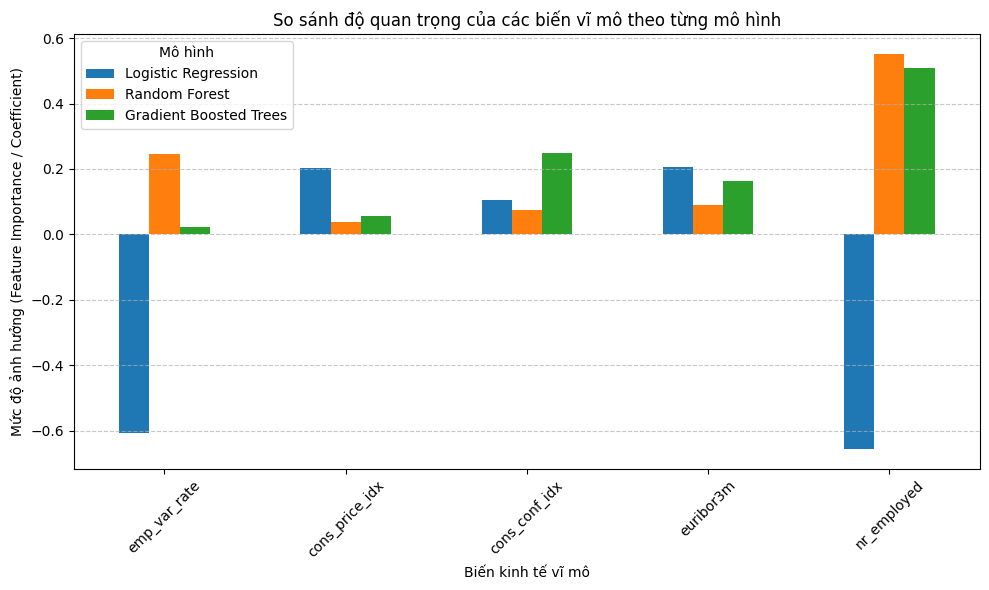

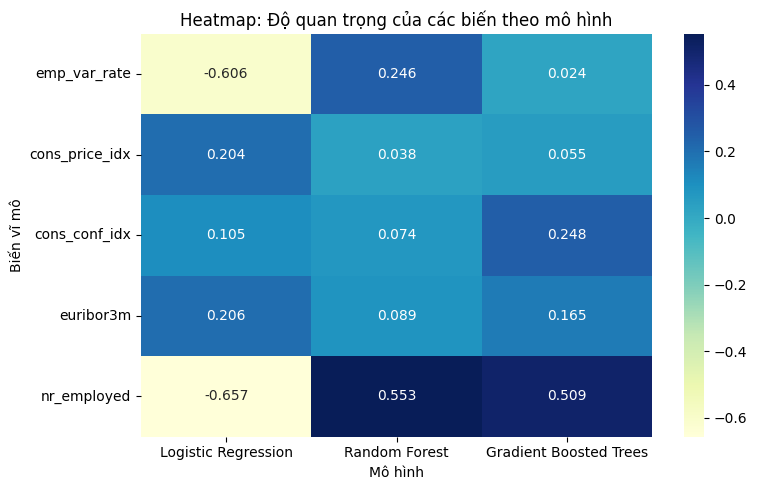

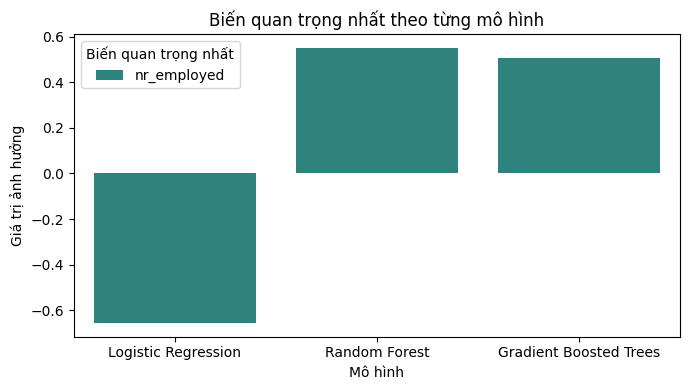

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Lưu trữ feature importance cho từng mô hình
importance_dict = {}

# 🔹 Lặp lại các mô hình đã train
for name, model in models.items():
    grid = ParamGridBuilder().build()
    cv = CrossValidator(estimator=model, estimatorParamMaps=grid, evaluator=evaluator, numFolds=3)
    
    cv_model = cv.fit(train_data)
    
    # Lấy thông tin độ quan trọng
    if hasattr(cv_model.bestModel, "featureImportances"):
        importances = cv_model.bestModel.featureImportances.toArray()
    elif hasattr(cv_model.bestModel, "coefficients"):
        importances = cv_model.bestModel.coefficients.toArray()
    else:
        importances = [0] * len(assembler.getInputCols())
    
    importance_dict[name] = pd.Series(importances, index=assembler.getInputCols())

# 🔹 Gộp lại thành DataFrame
importance_df = pd.DataFrame(importance_dict)
print("=== Bảng độ quan trọng các biến ===")
display(importance_df)

# =====================================================
# 🔸 Biểu đồ cột so sánh độ quan trọng các biến
# =====================================================
importance_df.plot(kind='bar', figsize=(10,6))
plt.title("So sánh độ quan trọng của các biến vĩ mô theo từng mô hình")
plt.xlabel("Biến kinh tế vĩ mô")
plt.ylabel("Mức độ ảnh hưởng (Feature Importance / Coefficient)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Mô hình")
plt.tight_layout()
plt.show()

# =====================================================
# 🔸 Biểu đồ heatmap
# =====================================================
plt.figure(figsize=(8,5))
sns.heatmap(importance_df, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Heatmap: Độ quan trọng của các biến theo mô hình")
plt.xlabel("Mô hình")
plt.ylabel("Biến vĩ mô")
plt.tight_layout()
plt.show()

# =====================================================
# 🔸 Biểu đồ: Biến quan trọng nhất của từng mô hình
# =====================================================
top_features = []
for model_name, series in importance_dict.items():
    top_feature = series.abs().idxmax()
    top_value = series[top_feature]
    top_features.append((model_name, top_feature, top_value))

top_df = pd.DataFrame(top_features, columns=["Model", "Top Feature", "Value"])

plt.figure(figsize=(7,4))
sns.barplot(data=top_df, x="Model", y="Value", hue="Top Feature", palette="viridis")
plt.title("Biến quan trọng nhất theo từng mô hình")
plt.xlabel("Mô hình")
plt.ylabel("Giá trị ảnh hưởng")
plt.legend(title="Biến quan trọng nhất")
plt.tight_layout()
plt.show()


## 📊 5️⃣ KẾT QUẢ ĐÁNH GIÁ


In [15]:
result_df = pd.DataFrame(results, columns=["Mô hình", "Precision", "Recall", "F1-score"])
print("=== BẢNG SO SÁNH HIỆU SUẤT MÔ HÌNH ===")
print(result_df)


=== BẢNG SO SÁNH HIỆU SUẤT MÔ HÌNH ===
                  Mô hình  Precision    Recall  F1-score
0     Logistic Regression   0.726237  0.713642  0.719884
1           Random Forest   0.823949  0.615458  0.704604
2  Gradient Boosted Trees   0.824245  0.610952  0.701749
